In [156]:
# %pip install matplotlib
import librosa.display
import numpy as np
from matplotlib import pyplot as plt
import os
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.optimizers import Adam

from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential

We will create Mel Spectrogram Images for each of the music files.These Mel spectrogram images will be used as INput for Our CNN model

In [157]:


def create_spectrogram(filename,name):
    plt.interactive(False)
    clip, sample_rate = librosa.load(filename, sr=None,duration=30)
    fig = plt.figure(figsize=[0.72,0.72])
    ax = fig.add_subplot(111)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)
    S = librosa.feature.melspectrogram(y=clip, sr=sample_rate)
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
    filename  = './' + name + '.jpg'
    plt.savefig(filename, dpi=800, bbox_inches='tight',pad_inches=0)
    plt.close()    
    fig.clf()
    plt.close(fig)
    plt.close('all')
    del filename,name,clip,sample_rate,fig,ax,S


For each of the music file I create one image file and store it in the images directory

In [51]:

filesnames=[]
genrenames=[]
for root, dirs, files in os.walk(path):
    for name in files:
        filename = os.path.join(root, name)
        filesnames.append(filename)
        
        genrenames.append(filename.split("/")[3])
try:
    os.mkdir('images')
except FileExistsError as e:
    None
finally:
    None
for name in set(genrenames):
    try:
        os.mkdir("./images/"+name)
    except FileExistsError as e:
        None    

data2/classical/classical.00020.wav
data2/classical/classical.00074.wav
data2/classical/classical.00092.wav
data2/classical/classical.00018.wav
data2/classical/classical.00045.wav
data2/classical/classical.00050.wav
data2/classical/classical.00064.wav
data2/classical/classical.00084.wav
data2/classical/classical.00011.wav
data2/classical/classical.00083.wav
data2/classical/classical.00099.wav
data2/classical/classical.00093.wav
data2/classical/classical.00015.wav
data2/classical/classical.00008.wav
data2/classical/classical.00026.wav
data2/classical/classical.00033.wav
data2/classical/classical.00096.wav
data2/classical/classical.00082.wav
data2/classical/classical.00006.wav
data2/classical/classical.00073.wav
data2/classical/classical.00049.wav
data2/classical/classical.00040.wav
data2/classical/classical.00007.wav
data2/classical/classical.00046.wav
data2/classical/classical.00048.wav
data2/classical/classical.00059.wav
data2/classical/classical.00058.wav
data2/classical/classical.00

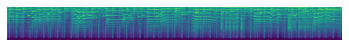

In [6]:
for i in range(len(filesnames)):
    
    genre=genrenames[i]
    filename=filesnames[i]
    endname=filename.split('/')
#     print(endname)
    endname=endname[-1]
#     print(endname)
    pathh="images/"+genre+"/"+endname
    print(pathh)
    create_spectrogram(filename,pathh)

### Loading Image Dataset

In [4]:
BATCH_SIZE=8
TARGET_SIZEX=223
TARGET_SIZEY=217
NUM_CLASSES=10
image_dataset=image_dataset_from_directory(
  "./images",
  validation_split=0.2,
  subset="training",
  seed=42,
  image_size=(TARGET_SIZEX, TARGET_SIZEY),
  batch_size=BATCH_SIZE)

Found 947 files belonging to 10 classes.
Using 758 files for training.


In [5]:
val_ds = image_dataset_from_directory(
   "./images",
  validation_split=0.2,
  subset="validation",
  seed=42,
  image_size=(TARGET_SIZEX, TARGET_SIZEY),
  batch_size=BATCH_SIZE)

Found 947 files belonging to 10 classes.
Using 189 files for validation.


## Building CNN

In [109]:
model_save = tf.keras.callbacks.ModelCheckpoint('./cnnmodel.h5', 
                             save_best_only = True, 
                             save_weights_only = False,
                             monitor = 'val_accuracy', 
                             mode = 'max', verbose = 1)
early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', 
                           patience = 10 ,mode = 'max', verbose = 1,
                           restore_best_weights = True)

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(TARGET_SIZEX, TARGET_SIZEY, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(NUM_CLASSES,activation="softmax")
])

In [110]:
model.compile(optimizer=Adam(lr = 0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 223, 217, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 223, 217, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 111, 108, 16)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 111, 108, 32)      4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 55, 54, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 55, 54, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 27, 27, 64)       

### Training

In [8]:

x=model.fit(
  image_dataset,
  validation_data=val_ds,
  epochs=40,
  verbose=2,
callbacks=[model_save,early_stop]
)

Epoch 1/40
95/95 - 20s - loss: 2.3117 - accuracy: 0.2164 - val_loss: 2.0901 - val_accuracy: 0.2804

Epoch 00001: val_accuracy improved from -inf to 0.28042, saving model to ./cnnmodel.h5
Epoch 2/40
95/95 - 19s - loss: 1.8828 - accuracy: 0.3166 - val_loss: 1.8282 - val_accuracy: 0.3122

Epoch 00002: val_accuracy improved from 0.28042 to 0.31217, saving model to ./cnnmodel.h5
Epoch 3/40
95/95 - 19s - loss: 1.7092 - accuracy: 0.3892 - val_loss: 1.7629 - val_accuracy: 0.3545

Epoch 00003: val_accuracy improved from 0.31217 to 0.35450, saving model to ./cnnmodel.h5
Epoch 4/40
95/95 - 19s - loss: 1.4867 - accuracy: 0.4749 - val_loss: 1.6843 - val_accuracy: 0.3862

Epoch 00004: val_accuracy improved from 0.35450 to 0.38624, saving model to ./cnnmodel.h5
Epoch 5/40
95/95 - 19s - loss: 1.2328 - accuracy: 0.5409 - val_loss: 1.5681 - val_accuracy: 0.4180

Epoch 00005: val_accuracy improved from 0.38624 to 0.41799, saving model to ./cnnmodel.h5
Epoch 6/40
95/95 - 19s - loss: 1.0219 - accuracy: 0.6

We got the best accuracy at epoch 28 and model was saved at this state

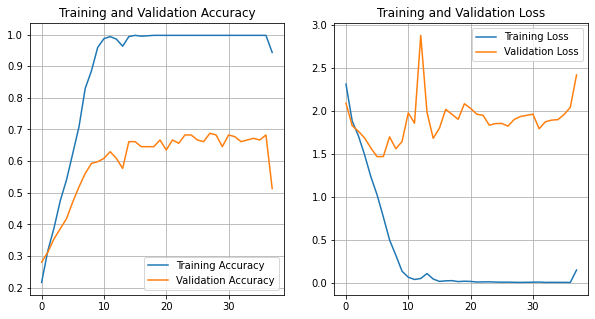

In [9]:
def plot_hist(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.grid()
    plt.show()
plot_hist(x)

In [28]:
y = []
x =[]
for images , label in val_ds.take(100) :
    for i in range(len(images)):

        x.append(images[i])
        y.append(label[i]) 


In [30]:
loss,acc=model.evaluate(val_ds)
print("Accuracy - ",acc)

24/24 [==============================] - 1s 44ms/step - loss: 1.9009 - accuracy: 0.6878
Accuracy -  0.6878306865692139


In [75]:
labels=val_ds.class_names

In [90]:
print(labels)

['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


In [158]:


def create_spectrogram(filename,name):
    plt.interactive(False)
    clip, sample_rate = librosa.load(filename, sr=None,duration=30)
    fig = plt.figure(figsize=[0.72,0.72])
    ax = fig.add_subplot(111)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)
    S = librosa.feature.melspectrogram(y=clip, sr=sample_rate)
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
    filename  = './' + name + '.jpg'
    plt.savefig(filename, dpi=800, bbox_inches='tight',pad_inches=0)
    plt.close()    
    fig.clf()
    plt.close(fig)
    plt.close('all')
    del filename,name,clip,sample_rate,fig,ax,S


def predict_single(path):
    create_spectrogram(path,"temp")
    image = tf.keras.preprocessing.image.load_img(path="./temp.jpg",target_size=(TARGET_SIZEX, TARGET_SIZEY))
    input_arr = tf.keras.preprocessing.image.img_to_array(image)
    input_arr = np.array([input_arr])  # Convert single image to a batch.
    predictions = model.predict(input_arr)
#     print(predictions[0])
    samp={}
    
    for i in range(10):
        samp[labels[i]]=predictions[0][i]
    return list({k: v for k, v in sorted(samp.items(), key=lambda item: item[1],reverse=True)}.keys())[:3]
#     return list(sorted(samp,reverse=True))
# model.predict()

In [159]:
model = keras.models.load_model('./cnnmodel.h5')

In [160]:
predict_single("./sample/bashful.wav")


['blues', 'jazz', 'reggae']

In [161]:
predict_single("./sample/sinceseventeen.wav")

['blues', 'country', 'rock']

In [162]:
predict_single("./sample/mytribe.wav")

['hiphop', 'reggae', 'metal']